In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from scipy.io import loadmat

In [2]:
spamTrain_sample = loadmat('spamTrain.mat')
X = spamTrain_sample['X'] # (4000, 1899)
y_label = spamTrain_sample['y'] # (4000, 1)
y_label = np.int_((y_label - 0.5)*2)

num_train = 4000

X = X[0:num_train, :]
y_label = y_label[0:num_train, :]

print("Shape of X: ", X.shape)
print("Shape of y_label: ", y_label.shape)
y_label = y_label.reshape(y_label.shape[0])
print("Shape of y_label after reshape: ", y_label.shape)


Shape of X:  (4000, 1899)
Shape of y_label:  (4000, 1)
Shape of y_label after reshape:  (4000,)


In [3]:
labels = y_label
print(labels.shape)

(4000,)


In [4]:
points = X.T
print(points.shape)
print(points)


(1899, 4000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
def gaussian_kernel(M):
    pass

# points_in_6d = np.apply_along_axis(polynomial_kernel, 0, points)
# print(points_in_6d.shape)
# print(points_in_6d[:,0])
# #for checking
# print(2**0.5*points[0,0])
# # d = yiyje^(xi - xj)
from scipy.spatial import distance_matrix
print(distance_matrix(points.T,points.T).shape)
norm_matrix = (distance_matrix(points.T,points.T))**2
print(np.diag(norm_matrix))

(4000, 4000)
[0. 0. 0. ... 0. 0. 0.]


In [23]:

# dataset = np.vstack([points_in_6d, labels])
# print(dataset.shape)
# print(dataset[:,51])

In [24]:
# YiXi = np.multiply(points_in_6d,labels.T)
# print(YiXi.shape)
# print(YiXi[:,51])

In [7]:
# D = YiXi.T @YiXi + np.eye(YiXi.shape[1])*1e-5
#print(labels.shape)
YiYj = labels[:, np.newaxis] @ labels[:, np.newaxis].T
#print(YiYj)
D = np.multiply(YiYj, np.exp(-1*norm_matrix/2)) + np.eye(norm_matrix.shape[0])*1e-5
print(np.argmax(D))
print(np.all(np.linalg.eigvals(D) >= 0))
print(np.linalg.eigvals(D))


0
True
[20.87140953+0.j 14.80490113+0.j 12.72439438+0.j ...  1.00001   +0.j
  1.00001   +0.j  1.00001   +0.j]


In [8]:
k = 2
C = 0.1
print(cp.settings.EIGVAL_TOL)
cp.settings.EIGVAL_TOL = 1e-08
#cp.solvers.options['abstol'] = 1e-10
from cvxpy.atoms.affine.wraps import psd_wrap

n_feat = X.shape[1]
n_train = X.shape[0]


lambd = cp.Variable(shape=(n_train,))
gamma = cp.Variable(shape=(n_train,))
objective = cp.Minimize(-cp.sum(lambd) + 0.5*cp.quad_form(lambd, psd_wrap(D)))

constraints= [lambd >= 0, lambd.T @ labels == 0 ,lambd <= C*np.ones(n_train,), lambd+gamma==C*np.ones(n_train)]
problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.ECOS)

1e-10


-237.85680994828616

In [9]:
print(lambd.value.T @labels)
print(lambd.value[np.where(lambd.value <=0)])

-3.405054016525355e-13
[]


In [10]:
lamb2 = np.round(lambd.value,3)
k = np.where((lamb2 < C) & (lamb2 > 0))
print(k)
print(np.round(lambd.value,3))

(array([   2,    3,    4, ..., 3996, 3998, 3999], dtype=int64),)
[0.1   0.1   0.048 ... 0.1   0.048 0.048]


In [15]:
len(k[0])

2692

In [11]:
from sklearn.kernel_approximation import RBFSampler

b = 0
rbf_feature = RBFSampler(gamma = 0.5 , random_state = 1, n_components = 5000)
print(labels.shape)
print(points.shape)
points_in_infd = rbf_feature.fit_transform(points.T).T
print(points_in_infd.shape)
YiXi = np.multiply(points_in_infd,labels.T)
j = np.multiply(YiXi, lambd.value.T)
print(j.shape)
w = np.sum(j,axis = 1)
print(w.shape)
print(w)

(4000,)
(1899, 4000)
(5000, 4000)
(5000, 4000)
(5000,)
[-0.0042648  -0.06131075 -0.06978035 ...  0.01313748 -0.00433603
  0.01354559]


In [34]:
some_num = 100
for i in k:
     print(labels[i] - w.T @ points_in_infd[:,i])
b = labels[k[0]] - w.T @ points_in_infd[:,k[0]]
b= max(b)
# print(max(b))

[-0.85521481 -0.84396599 -0.92154752 ... -0.99572641 -0.90395484
 -1.02893131]


In [35]:
print(np.where(w.T @ points_in_infd + b >=0))
print(len(np.where(w.T @ points_in_infd + b >=0)[0]))

(array([  46,  152,  153,  188,  242,  244,  248,  257,  357,  401,  430,
        463,  528,  573,  606,  711,  732,  792,  834,  859,  884,  907,
        922,  951,  955,  958,  979, 1003, 1016, 1082, 1194, 1287, 1333,
       1374, 1453, 1465, 1468, 1473, 1549, 1602, 1629, 1630, 1702, 1803,
       1820, 1884, 2025, 2079, 2089, 2130, 2156, 2261, 2262, 2283, 2433,
       2498, 2528, 2602, 2605, 2616, 2625, 2673, 2744, 2762, 2903, 2936,
       2959, 3013, 3022, 3047, 3290, 3291, 3359, 3490, 3576, 3591, 3620,
       3653, 3673, 3758, 3782, 3797, 3799, 3800, 3814, 3897], dtype=int64),)
86


In [22]:
print(np.where(w.T @ points_in_infd + b <=0))
print(len(np.where(w.T @ points_in_infd + b <=0)[0]))

(array([   0,    1,    2, ..., 3997, 3998, 3999], dtype=int64),)
3940


In [90]:
# h = 0.02
# x_min, x_max = points[0, :].min() - 1, points[0, :].max() + 1
# y_min, y_max = points[1, :].min() - 1, points[1, :].max() + 1
# print(x_min, x_max)
# print(y_min,y_max)
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))
# print(xx.shape)

-3.2212575036992632 3.5730260083918064
-3.405434719073713 3.654481663898312
(353, 340)


In [96]:
# def gaussian_hyperplane(x,y,w,b):
#     x_feat = rbf_feature.transform([[x,y], [x, y]])[0, :]
#     return (w.T @ x_feat + b)


In [97]:
# Z = np.ones((xx.shape))
# for i in range(xx.shape[0]):
#     for j in range(xx.shape[1]):
#         Z[i][j] = gaussian_hyperplane(xx[i][j],yy[i][j],w,b)

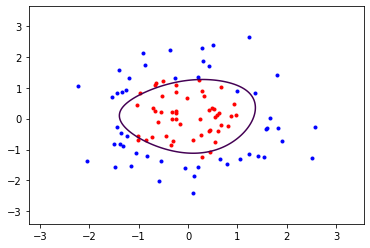

In [98]:
# plt.plot(Pos[0,:], Pos[1,:], 'r.')
# plt.plot(Neg[0,:], Neg[1,:], 'b.')
# plt.contour(xx, yy, Z,[0])
# plt.show()